In [1]:
!pip install gym-anytrading -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 3.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gym_anytrading
import gym
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [4]:
import numpy as np
import random
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
from skimage.color import rgb2gray
import pickle
import torch.optim as optim
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

In [6]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        # self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick =None
        self._end_tick = None
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )


    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
!unzip -x '/content/drive/MyDrive/RLtrader/df.zip'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Archive:  /content/drive/MyDrive/RLtrader/df.zip
  inflating: df.csv                  


In [10]:
df = pd.read_csv('/content/df.csv')

In [11]:
df['Close_norm']=df.Close /100000

In [12]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open_x,High_x,Low_x,Close_x,Volume_x,Quote Asset Volume_x,Number of Trades_x,Taker buy base asset volume_x,Taker buy quote asset volume_x,BTC_rsi,...,High_y,Low_y,Close_y,Volume_y,Quote Asset Volume_y,Number of Trades_y,Taker buy base asset volume_y,Taker buy quote asset volume_y,Close,Close_norm
0,0.666106,0.662248,0.668920,0.666743,0.023361,0.027755,0.032974,0.022409,0.025850,0.540618,...,0.857247,0.866818,0.861622,0.010763,0.011431,0.003867,0.014329,0.017029,21309.78,0.213098
1,0.666730,0.662102,0.669312,0.666809,0.013900,0.016649,0.029026,0.012014,0.013946,0.560111,...,0.858162,0.868506,0.862188,0.005457,0.005809,0.005380,0.002729,0.003254,21310.36,0.213104
2,0.666706,0.661949,0.669020,0.666131,0.014062,0.016837,0.025134,0.010032,0.011674,0.354888,...,0.857814,0.868600,0.861717,0.003710,0.003954,0.003074,0.000795,0.000956,21304.46,0.213045
3,0.666118,0.661863,0.669084,0.666469,0.010292,0.012412,0.025351,0.009629,0.011214,0.481042,...,0.858114,0.868600,0.862173,0.006951,0.007394,0.005801,0.001582,0.001891,21307.40,0.213074
4,0.666546,0.663236,0.669474,0.667932,0.025500,0.030277,0.045354,0.024815,0.028615,0.757098,...,0.860133,0.869042,0.864516,0.010043,0.010680,0.007537,0.011311,0.013460,21320.12,0.213201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145309,0.769223,0.764653,0.771573,0.769173,0.019545,0.024301,0.030452,0.014066,0.017019,0.125329,...,0.750114,0.759850,0.753467,0.009355,0.009522,0.010611,0.006394,0.007287,22200.20,0.222002
145310,0.769256,0.764749,0.771946,0.769763,0.006948,0.008893,0.018058,0.007533,0.009224,0.458795,...,0.749499,0.760023,0.754238,0.002041,0.002088,0.002950,0.001757,0.002009,22205.33,0.222053
145311,0.769749,0.764997,0.771976,0.769225,0.013981,0.017498,0.023837,0.008373,0.010228,0.312523,...,0.750051,0.760623,0.754081,0.006187,0.006304,0.004586,0.003338,0.003810,22200.65,0.222007
145312,0.769318,0.764265,0.771405,0.769210,0.012208,0.015325,0.014815,0.008399,0.010255,0.308861,...,0.749341,0.760071,0.753782,0.005458,0.005560,0.005652,0.005025,0.005728,22200.52,0.222005


In [13]:
import numpy as np

from gym_anytrading.envs import  Actions, Positions
from gym import spaces

class my_StocksEnv(TradingEnv):

    def __init__(self, df, window_size, episode_length):
        assert type(episode_length) == int
        assert df.ndim == 2

        self.episode_length = episode_length
        # super().__init__(df, window_size)
        self.seed()
        self.df = df
        self.window_size = window_size


        _,_,self.signal_features = self._process_data()


        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)


        self.trade_fee_bid_percent = 0 # unit
        self.trade_fee_ask_percent =0# unit
        # episode
        self._start_tick = None
        self._end_tick = None
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def _process_data(self):
      start = np.random.randint(self.window_size,len(self.df)-self.episode_length)
      end = start + self.episode_length
      prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
      normalized_prices = self.df.loc[:, 'Close_norm'].to_numpy()[start:end]
      signal_features = self.df.loc[:, ['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Quote Asset Volume_x', 'Number of Trades_x',
       'Taker buy base asset volume_x', 'Taker buy quote asset volume_x',
       'BTC_rsi', 'BTC_md', 'ETH_md', 'ETH_rsi', 'Open_y', 'High_y', 'Low_y',
       'Close_y', 'Volume_y', 'Quote Asset Volume_y', 'Number of Trades_y',
       'Taker buy base asset volume_y', 'Taker buy quote asset volume_y']].to_numpy()[start:end]
      return prices,normalized_prices, signal_features

    def reset(self):
        self.prices,self.normalized_prices, self.signal_features = self._process_data()
        self._start_tick = self.window_size
        self._end_tick = self.episode_length -1
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def _calculate_reward(self, action):
        step_reward=0
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.normalized_prices[self._current_tick]
            last_trade_price = self.normalized_prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            if self._position == Positions.Long:
              # trade_reward=1 if price_diff>0 else -1
              step_reward += price_diff
            elif self._position == Positions.Short:
                # trade_reward=-1 if price_diff<0 else 1
                step_reward = -(price_diff)

        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

info: {'total_reward': -0.0008969000000000893, 'total_profit': 0.9986857841462471, 'position': 1}


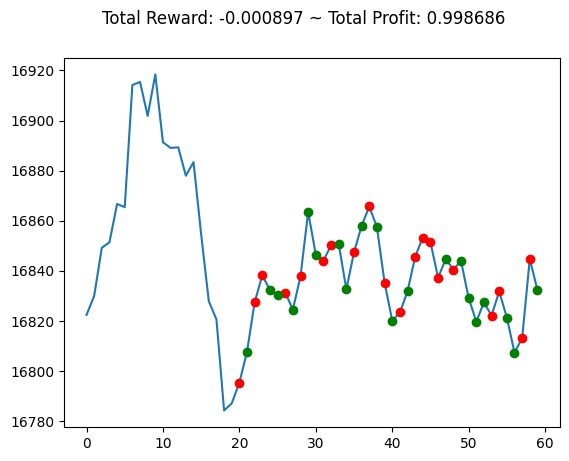

In [14]:
env = my_StocksEnv(df,20,60)

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

In [15]:
class Network(nn.Module):
    def __init__(self,input_size,out_size,hidden_space):
        super(Network,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        self.hidden_space = hidden_space
        self.fc1 = nn.Linear(in_features=self.input_size,out_features=self.hidden_space)
        self.lstm = nn.LSTM(input_size=self.hidden_space,hidden_size=self.hidden_space,num_layers=1,batch_first=True)
        self.fc2 = nn.Linear(in_features=self.hidden_space,out_features=self.out_size)
        self.relu = nn.ReLU()
    def forward(self,x,h,c):
        output = self.fc1(x)
        output = self.relu(output)
        output,(h_n,c_n) = self.lstm(output,(h,c))
        output = self.fc2(output)
        return output, (h_n,c_n)

In [16]:
class Memory():
  def __init__(self,length):
    self.memory_size = length
    self.memory = deque(maxlen=self.memory_size)
  def add(self,epsiode):
    self.memory.append(epsiode)
  def __len__(self):
    return len(self.memory)
  def get_batch(self,batch_size):
    samples = random.sample(self.memory,batch_size)
    observations = []
    actions = []
    rewards = []
    next_obs = []
    dones =  []
    for sample in samples:
      observations.append(sample[0])
      actions.append(sample[1])
      rewards.append(sample[2])
      next_obs.append(sample[3])
      dones.append(sample[4])
    batch = {'obs':observations,
                  'action':actions,
                  'rewards':rewards,
                  'next_obs':next_obs,
                  'done':dones}
    return batch

In [17]:
env = my_StocksEnv(df.iloc[:-1440],1,1440)
experience_replay = Memory(300)

In [18]:
batch_size = 128
hidden_space = 256
gamma = 0.9
seq_len=1438
device='cuda'

In [19]:
Q_net = Network(22,2,hidden_space).to(device)
target = Network(22,2,hidden_space).to(device)
target.load_state_dict(Q_net.state_dict())

<All keys matched successfully>

In [20]:
def choose_action(Q_net,observation,h,c,epsilon):
  if np.random.random() < epsilon:
    action = np.random.choice([0,1])
  else:
    with torch.no_grad():
      Q_values,(h,c) =Q_net(torch.tensor(observation,dtype=torch.float32).to(device),h,c)
      action = Q_values.squeeze().argmax().item()
  return action,h,c

In [21]:
total_loss = []
total_reward = []
h,c =  torch.zeros([1, hidden_space]).to(device), torch.zeros([1, hidden_space]).to(device)
h_b,c_b =  torch.zeros([1, batch_size, hidden_space]).to(device), torch.zeros([1, batch_size, hidden_space]).to(device)
optimizer = optim.Adam(Q_net.parameters(), lr=0.01)
for iteration in range(2000):
  obs = env.reset()
  done = False
  actions = []
  observations =[]
  rewards = []
  dones = []
  next_observations =[]
  episode_reward = 0
  epsilon=max(1e-3,np.exp(-0.0001*iteration))
  while True:
    action,h,c = choose_action(Q_net,obs,h,c,epsilon=epsilon)
    next_obs,reward,done,_ = env.step(action)
    actions.append(action)
    dones.append(done)
    observations.append(obs.flatten())
    next_observations.append(next_obs.flatten())
    rewards.append(reward)
    episode_reward +=reward
    if done:
      break
    obs = next_obs
  experience_replay.add((observations,actions,rewards,next_observations,dones))
  if len(experience_replay) >= batch_size:
    total_reward.append(episode_reward)
    batch =experience_replay.get_batch(batch_size)
    observations = np.array(batch['obs'])
    actions = np.array(batch['action'])
    rewards = np.array(batch['rewards'])
    next_observations = np.array(batch['next_obs'])
    dones = np.array(batch['done'])
    observations = torch.FloatTensor(observations.reshape(batch_size,seq_len,-1)).to(device)
    actions = torch.LongTensor(actions.reshape(batch_size,seq_len,-1)).to(device)
    rewards = torch.FloatTensor(rewards.reshape(batch_size,seq_len,-1)).to(device)
    next_observations = torch.FloatTensor(next_observations.reshape(batch_size,seq_len,-1)).to(device)
    dones = torch.FloatTensor(dones.reshape(batch_size,seq_len,-1)).to(device)
    h_0,c_0 =  torch.zeros([1, batch_size, hidden_space]).to(device), torch.zeros([1, batch_size, hidden_space]).to(device)
    q_target, _= target(next_observations, h_0, c_0)
    q_target_max = q_target.max(2)[0].view(batch_size,seq_len,-1).detach()
    targets = rewards + gamma*q_target_max*dones
    q_out, _ = Q_net(observations, h_0,c_0)
    q_a = q_out.gather(2, actions)
    loss = F.smooth_l1_loss(q_a, targets)
    total_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if iteration % 50 == 0:
    target.load_state_dict(Q_net.state_dict())
    if iteration > batch_size:
      print(f'Iteration: {iteration} Average Loss:{np.mean(total_loss[-50:])} Average Total Reward: {np.mean(total_reward[-50:])}','\n')

Iteration: 150 Average Loss:0.0983149773273908 Average Total Reward: 0.0023855874999999527 

Iteration: 200 Average Loss:4.139642614973127e-05 Average Total Reward: -0.001538936000000053 

Iteration: 250 Average Loss:5.952783403699869e-06 Average Total Reward: -0.0012310819999999734 

Iteration: 300 Average Loss:1.997223130274506e-06 Average Total Reward: 0.0007389859999998371 

Iteration: 350 Average Loss:1.43492087318009e-06 Average Total Reward: -0.0006513359999999429 

Iteration: 400 Average Loss:1.0376504235409812e-06 Average Total Reward: -0.0007132499999999742 

Iteration: 450 Average Loss:7.963814562117477e-07 Average Total Reward: -0.00035727399999996746 

Iteration: 500 Average Loss:5.488850723622818e-07 Average Total Reward: 4.5537999999762936e-05 

Iteration: 550 Average Loss:3.615841154669397e-07 Average Total Reward: 0.00013286999999996386 

Iteration: 600 Average Loss:3.211870958352847e-07 Average Total Reward: -0.000764933999999925 

Iteration: 650 Average Loss:2.589929

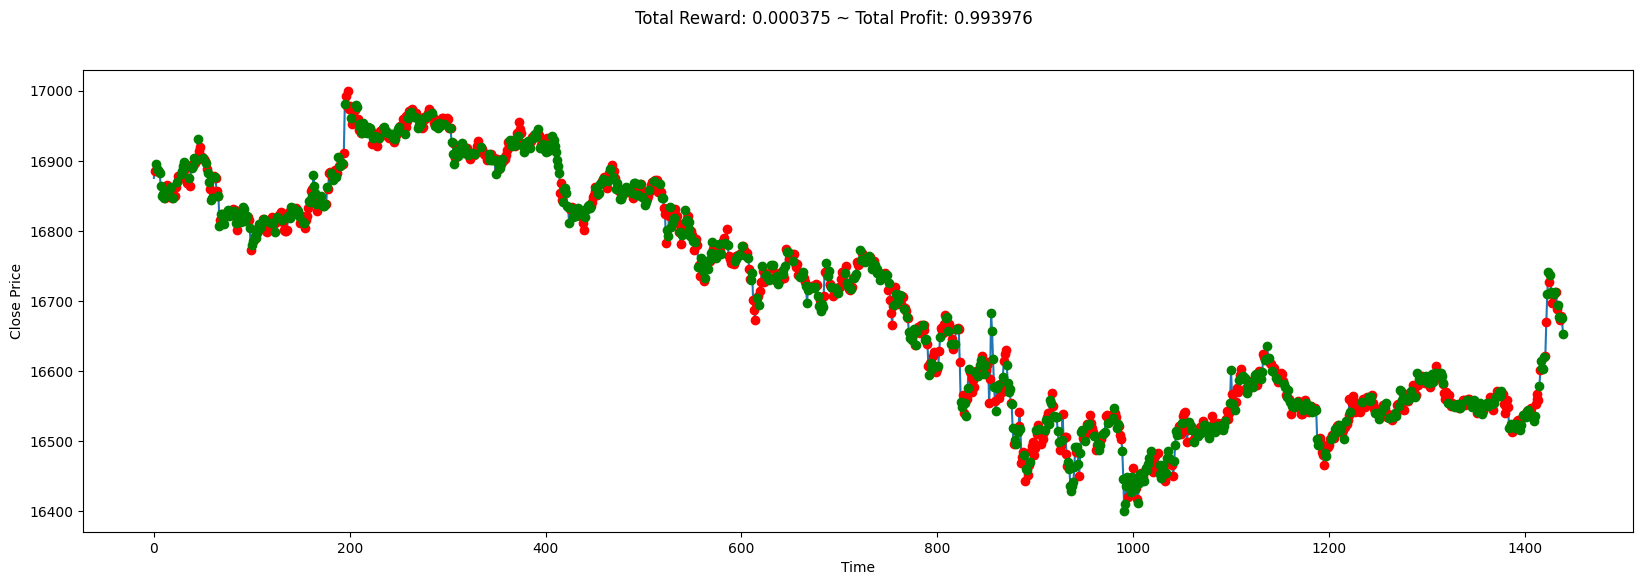

In [22]:
plt.figure(figsize=(20,6))
plt.cla()
env.render_all()
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.show()

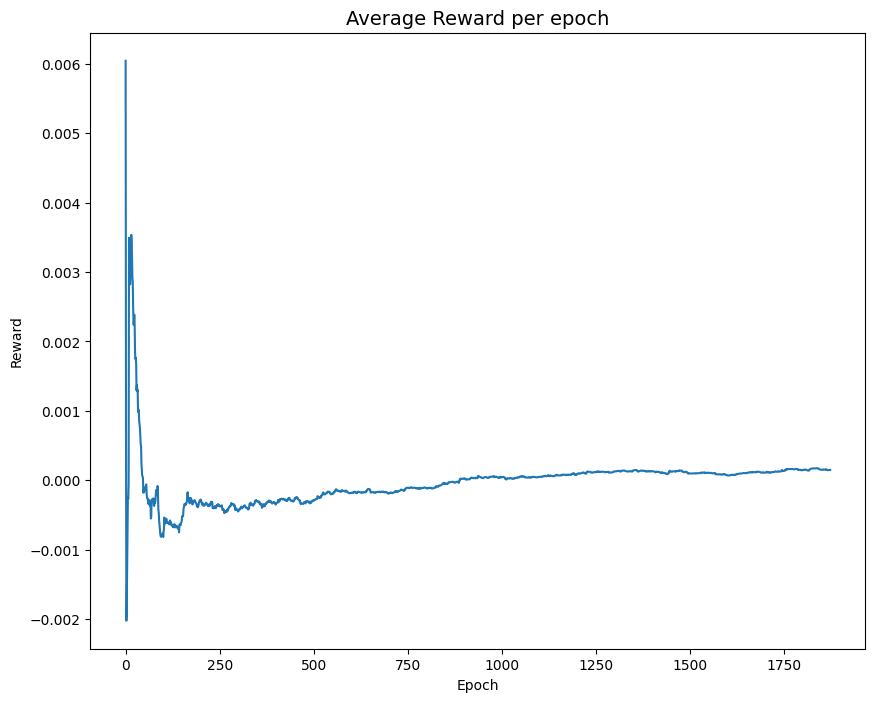

In [24]:
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(total_reward)/np.arange(1,len(total_reward)+1))
plt.title('Average Reward per epoch',size=14)
plt.ylabel('Reward')
plt.xlabel('Epoch')
plt.show()

In [25]:
env = my_StocksEnv(df.iloc[-1450:],1,1440)

In [26]:
h,c =  torch.zeros([1, hidden_space]).to(device), torch.zeros([1, hidden_space]).to(device)
epsilon=0.001
obs= env.reset()
while True:
  action,h,c = choose_action(Q_net,obs,h,c,epsilon=epsilon)
  obs,reward,done,info = env.step(action)

  if done:
    break


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


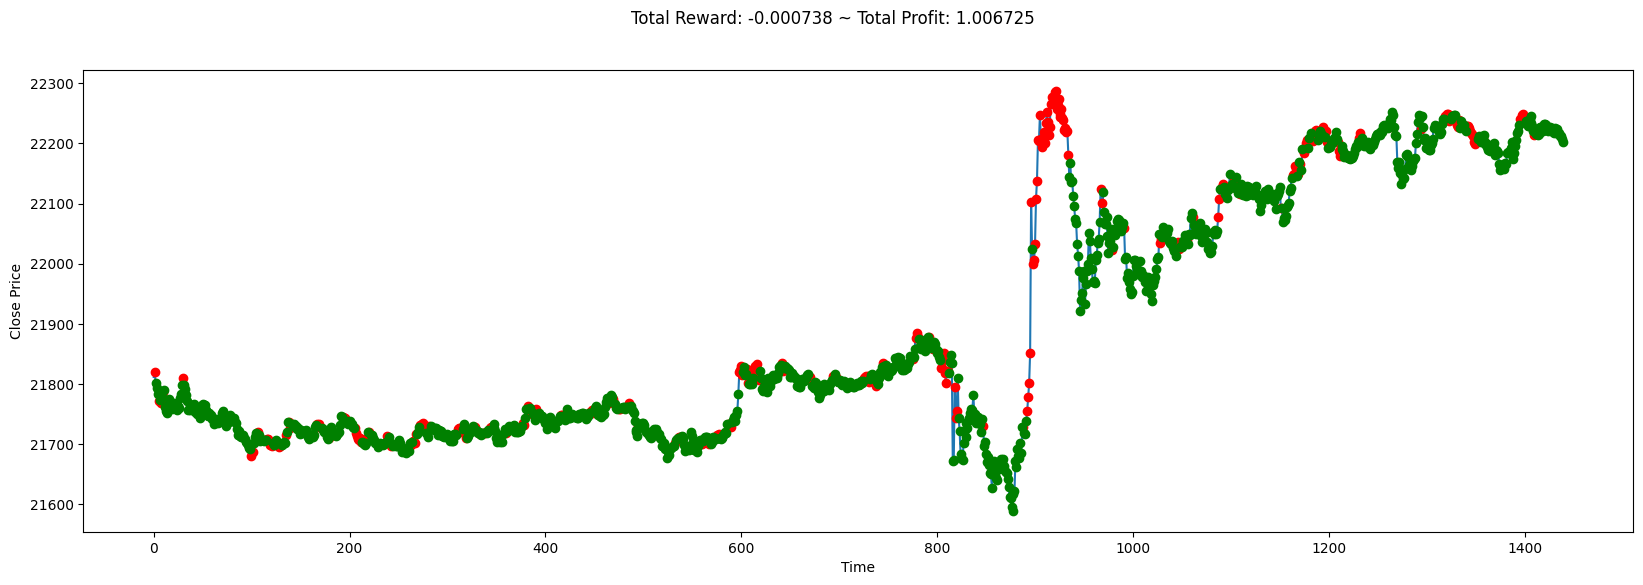

In [27]:
plt.figure(figsize=(20,6))
plt.cla()
env.render_all()
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.show()